# Discover ML with Ames, Ioha House pricing dataset

## Import libraries and data

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Setup Seaborn style
sns.set(rc={'figure.figsize':(15,8)})

In [0]:
selected_features=[
    'SalePrice',
    'MSZoning', 
    'LotArea', 
    'Neighborhood', 
    'HouseStyle', 
    'OverallQual', 
    'OverallCond', 
    'YearBuilt', 
    'Foundation', 
    'Heating', 
    'CentralAir', 
    'GrLivArea', 
    'BedroomAbvGr', 
    'KitchenQual', 
    'FullBath',
    'HalfBath',
    'Fireplaces',
    'GarageType',
    'GarageCars',
    'PoolArea'
]

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/cloderic/ml_intro/master/data/house_prices/data.csv', index_col='Id')
df = df[selected_features]
df.head()

,SalePrice,MSZoning,LotArea,Neighborhood,HouseStyle,OverallQual,OverallCond,YearBuilt,Foundation,Heating,CentralAir,GrLivArea,BedroomAbvGr,KitchenQual,FullBath,HalfBath,Fireplaces,GarageType,GarageCars,PoolArea
Id,,,,,,,,,,,,,,,,,,,,
1,208500,RL,8450,CollgCr,2Story,7,5,2003,PConc,GasA,Y,1710,3,Gd,2,1,0,Attchd,2,0
2,181500,RL,9600,Veenker,1Story,6,8,1976,CBlock,GasA,Y,1262,3,TA,2,0,1,Attchd,2,0
3,223500,RL,11250,CollgCr,2Story,7,5,2001,PConc,GasA,Y,1786,3,Gd,2,1,1,Attchd,2,0
4,140000,RL,9550,Crawfor,2Story,7,5,1915,BrkTil,GasA,Y,1717,3,Gd,1,0,1,Detchd,3,0
5,250000,RL,14260,NoRidge,2Story,8,5,2000,PConc,GasA,Y,2198,4,Gd,2,1,1,Attchd,3,0


In [4]:
metadata_df = pd.read_json('https://raw.githubusercontent.com/cloderic/ml_intro/master/data/house_prices/data_description.json')
metadata_df = metadata_df.loc[metadata_df['feature'].isin(selected_features)].set_index('feature')
metadata_df

,description,values
feature,,
MSZoning,Identifies the general zoning classification o...,"{'A': 'Agriculture', 'C': 'Commercial', 'FV': ..."
LotArea,Lot size in square feet,NaN
Neighborhood,Physical locations within Ames city limits,"{'Blmngtn': 'Bloomington Heights', 'Blueste': ..."
HouseStyle,Style of dwelling,"{'1Story': 'One story', '1.5Fin': 'One and one..."
OverallQual,Rates the overall material and finish of the h...,"{'1': 'Very Poor', '2': 'Poor', '3': 'Fair', '..."
OverallCond,Rates the overall condition of the house,"{'1': 'Very Poor', '2': 'Poor', '3': 'Fair', '..."
YearBuilt,Original construction date,NaN
Foundation,Type of foundation,"{'BrkTil': 'Brick & Tile', 'CBlock': 'Cinder B..."
Heating,Type of heating,"{'Floor': 'Floor Furnace', 'GasA': 'Gas forced..."


## Data Exploration

### Price distribution

In [5]:
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

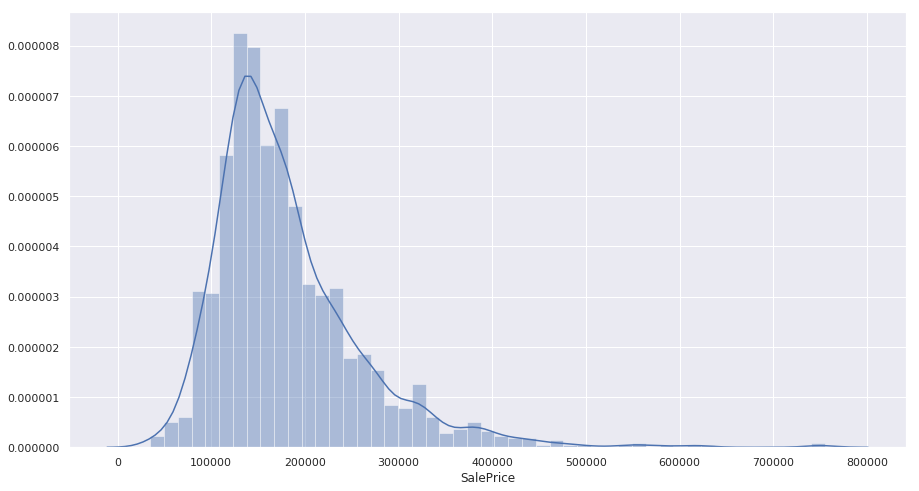

In [6]:
sns.distplot(df['SalePrice']);

In [7]:
df_g_neighborhood = df.groupby(by='Neighborhood')
df_g_neighborhood['SalePrice'].describe().sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Neighborhood,,,,,,,,
NoRidge,41.0,335295.317073,121412.658640,190000.0,265000.00,301500.0,341000.00,755000.0
NridgHt,77.0,316270.623377,96392.544954,154000.0,253293.00,315000.0,374000.00,611657.0
StoneBr,25.0,310499.000000,112969.676640,170000.0,213500.00,278000.0,377426.00,556581.0
Timber,38.0,242247.447368,64845.651549,137500.0,186900.00,228475.0,286115.75,378500.0
Veenker,11.0,238772.727273,72369.317959,162500.0,184250.00,218000.0,282000.00,385000.0
Somerst,86.0,225379.837209,56177.555888,144152.0,177975.00,225500.0,252919.50,423000.0
ClearCr,28.0,212565.428571,50231.538993,130000.0,183750.00,200250.0,242225.00,328000.0
Crawfor,51.0,210624.725490,68866.395472,90350.0,159250.00,200624.0,239000.00,392500.0
CollgCr,150.0,197965.773333,51403.666438,110000.0,152958.75,197200.0,225725.00,424870.0


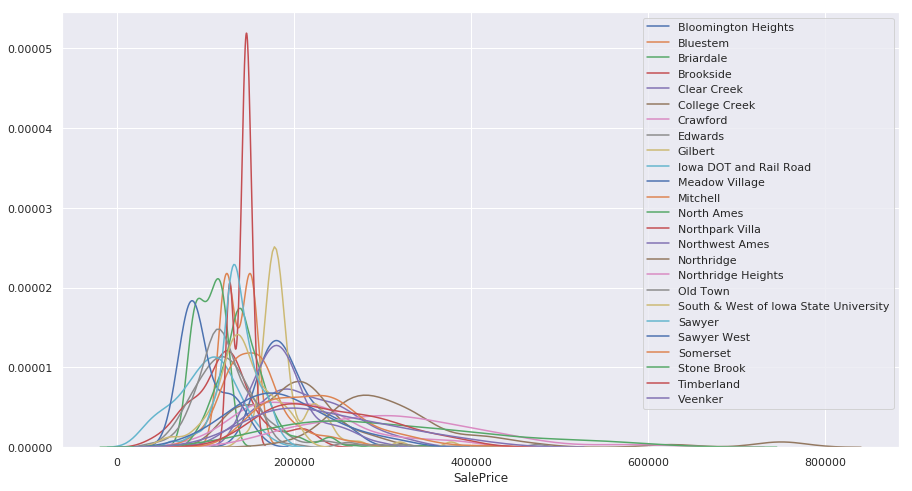

In [8]:
for neighborhood, df_neighborhood in df.groupby(by='Neighborhood'):
  sns.distplot(df_neighborhood['SalePrice'], hist=False, rug=False, label=metadata_df['values']['Neighborhood'][neighborhood])

### Relationship with other numerical features

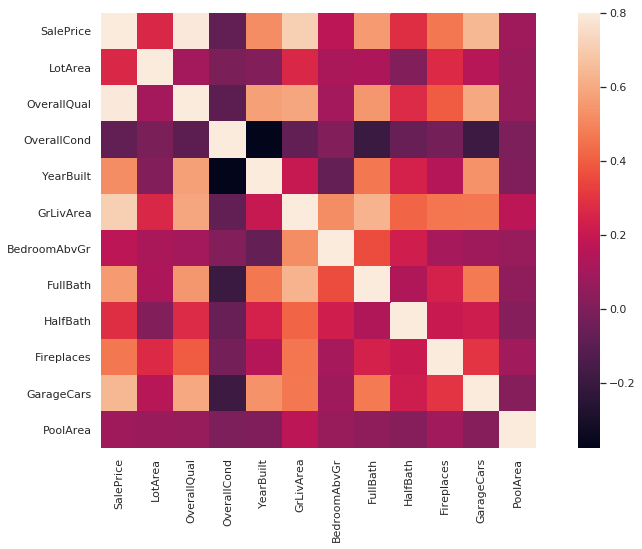

In [9]:
corrmat = df.corr()
sns.heatmap(corrmat, vmax=.8, square=True);

In [10]:
correlations_df = pd.DataFrame({ 'correlation': corrmat['SalePrice'] })
correlations_df = pd.merge(correlations_df, metadata_df[['description']], how='left', left_index=True, right_index=True).sort_values('correlation', ascending=False)
correlations_df

,correlation,description
SalePrice,1.000000,NaN
OverallQual,0.790982,Rates the overall material and finish of the h...
GrLivArea,0.708624,Above grade (ground) living area square feet
GarageCars,0.640409,Size of garage in car capacity
FullBath,0.560664,Full bathrooms above grade
YearBuilt,0.522897,Original construction date
Fireplaces,0.466929,Number of fireplaces
HalfBath,0.284108,Half baths above grade
LotArea,0.263843,Lot size in square feet
BedroomAbvGr,0.168213,Bedrooms above grade (does NOT include basemen...


#### Price vs Living Area

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


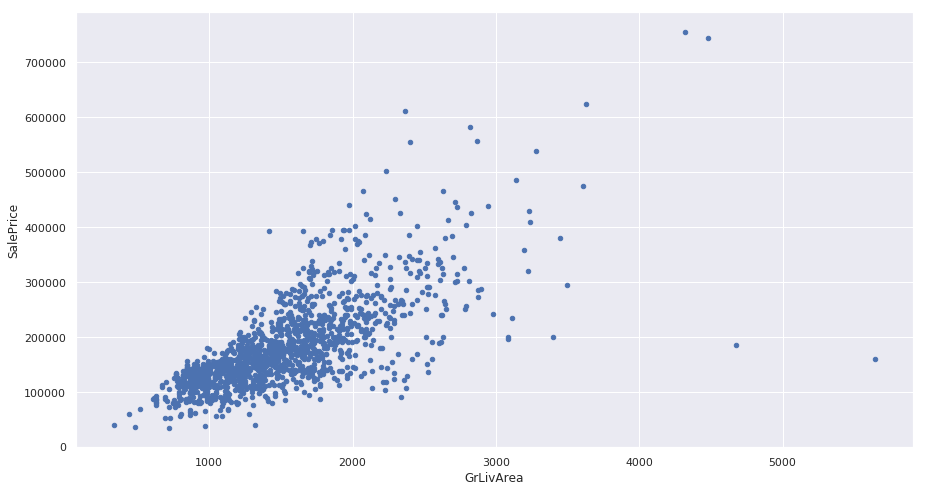

In [11]:
data = pd.concat([df['SalePrice'], df['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice');

#### Price vs Porch area

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


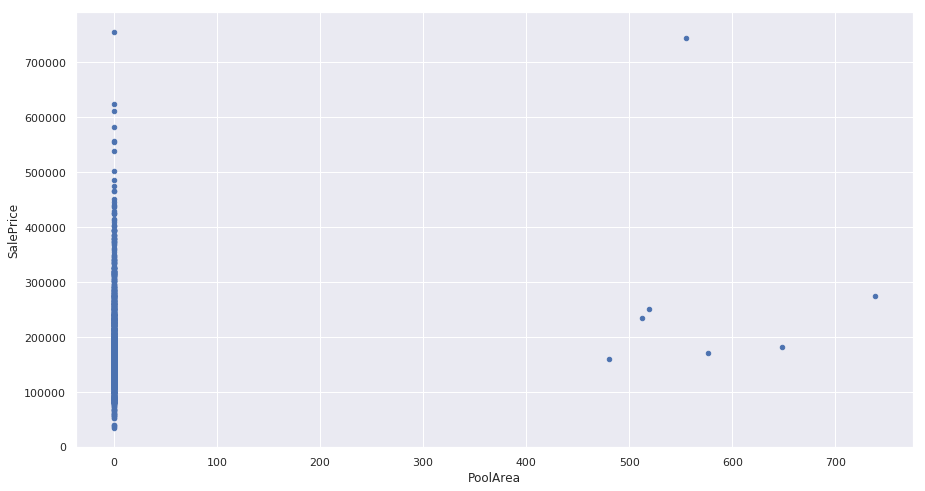

In [12]:
data = pd.concat([df['SalePrice'], df['PoolArea']], axis=1)
data.plot.scatter(x='PoolArea', y='SalePrice');

#### Price vs Overall Quality

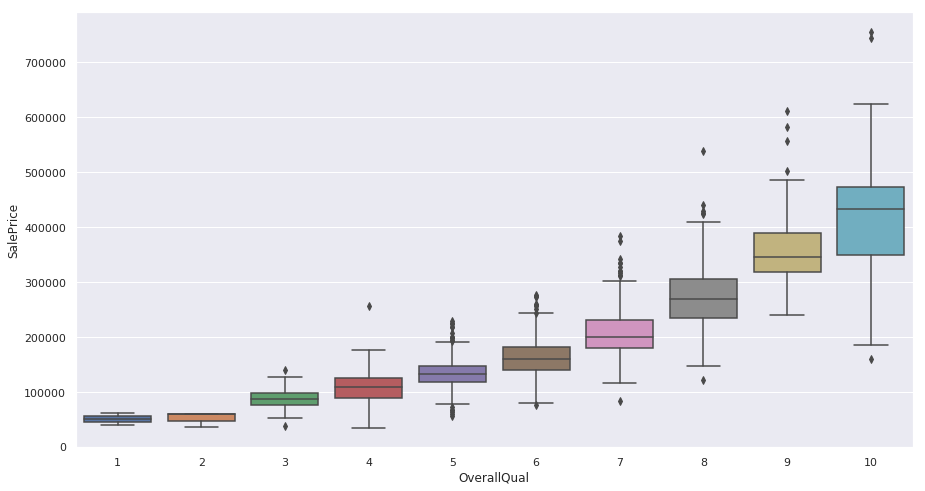

In [13]:
data = pd.concat([df['SalePrice'], df['OverallQual']], axis=1)
sns.boxplot(x='OverallQual', y="SalePrice", data=data)

#### Price vs Overall condition

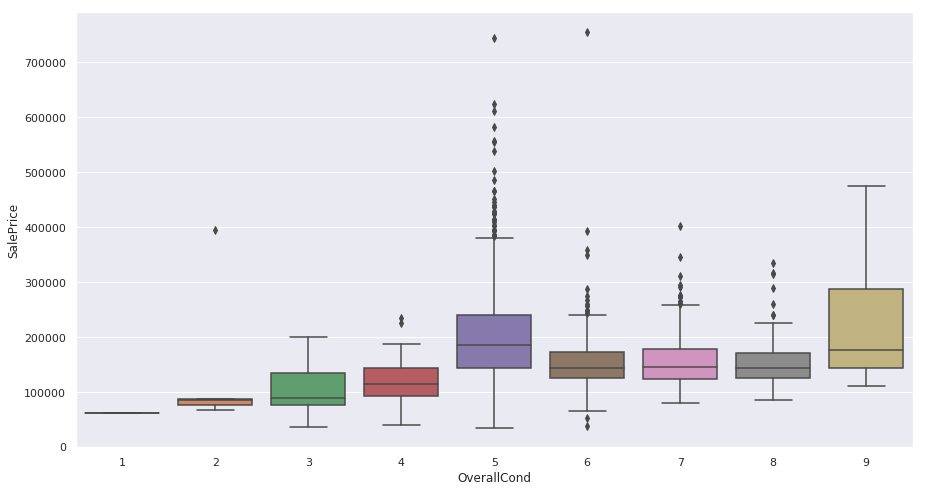

In [14]:
data = pd.concat([df['SalePrice'], df['OverallCond']], axis=1)
sns.boxplot(x='OverallCond', y="SalePrice", data=data)

### Encoding categorical features

In [15]:
categorical_features = list(set(df.columns) - set(df._get_numeric_data().columns))
categorical_features

['KitchenQual',
 'CentralAir',
 'MSZoning',
 'Neighborhood',
 'HouseStyle',
 'GarageType',
 'Foundation',
 'Heating']

In [16]:
df['HouseStyle'].value_counts(), metadata_df['values']['HouseStyle']

(1Story    726
 2Story    445
 1.5Fin    154
 SLvl       65
 SFoyer     37
 1.5Unf     14
 2.5Unf     11
 2.5Fin      8
 Name: HouseStyle, dtype: int64,
 {'1.5Fin': 'One and one-half story, 2nd level finished',
  '1.5Unf': 'One and one-half story, 2nd level unfinished',
  '1Story': 'One story',
  '2.5Fin': 'Two and one-half story, 2nd level finished',
  '2.5Unf': 'Two and one-half story, 2nd level unfinished',
  '2Story': 'Two story',
  'SFoyer': 'Split Foyer',
  'SLvl': 'Split Level'})

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

onehot_encoded_features = ['MSZoning','CentralAir','HouseStyle','Neighborhood','Foundation','Heating']
onehot_encoder = OneHotEncoder(sparse=False, drop='first')
onehot_encoder.fit(df[onehot_encoded_features])

kitchen_qual_encoder = OrdinalEncoder([['Po', 'TA', 'Fa', 'Gd', 'Ex']])
kitchen_qual_encoder.fit(df[['KitchenQual']])

encoded_df = pd.concat([df,
                        pd.DataFrame(data=onehot_encoder.transform(df[onehot_encoded_features]), columns=onehot_encoder.get_feature_names(onehot_encoded_features), index=df.index),
                        pd.DataFrame(data=kitchen_qual_encoder.transform(df[['KitchenQual']]), columns=['EncodedKitchenQual'], index=df.index)
                       ], axis=1)

encoded_df = encoded_df.drop(categorical_features, axis=1)
encoded_df

,SalePrice,LotArea,OverallQual,OverallCond,YearBuilt,GrLivArea,BedroomAbvGr,FullBath,HalfBath,Fireplaces,GarageCars,PoolArea,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,CentralAir_Y,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,EncodedKitchenQual
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,208500,8450,7,5,2003,1710,3,2,1,0,2,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
2,181500,9600,6,8,1976,1262,3,2,0,1,2,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,223500,11250,7,5,2001,1786,3,2,1,1,2,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
4,140000,9550,7,5,1915,1717,3,1,0,1,3,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
5,250000,14260,8,5,2000,2198,4,2,1,1,3,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
6,143000,14115,5,5,1993,1362,1,1,1,0,2,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
7,307000,10084,8,5,2004,1694,3,2,0,1,2,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
8,200000,10382,7,6,1973,2090,3,2,1,2,2,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
9,129900,6120,7,5,1931,1774,2,2,0,2,2,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


### Update the correlation matrix with the encoded features

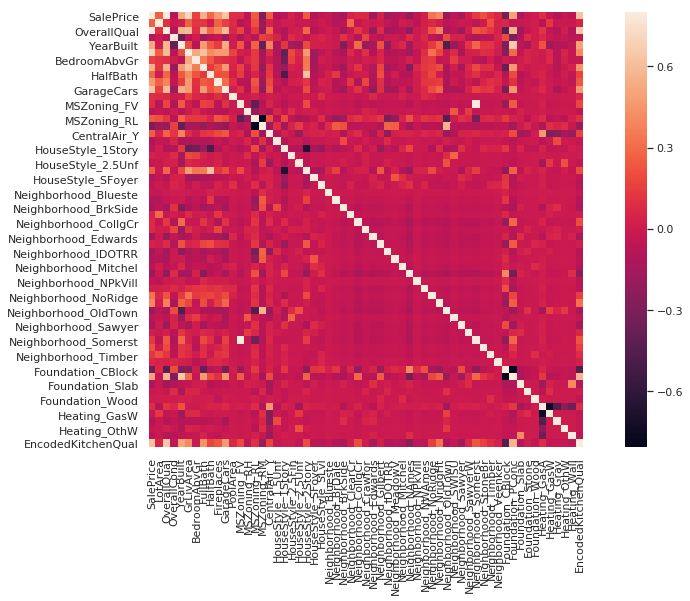

In [18]:
corrmat = encoded_df.corr()
sns.heatmap(corrmat, vmax=.8, square=True);

In [19]:
correlations_df = pd.DataFrame({ 'correlation': corrmat['SalePrice'] })
correlations_df = correlations_df.sort_values('correlation', ascending=False)
correlations_df

,correlation
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
EncodedKitchenQual,0.619235
FullBath,0.560664
YearBuilt,0.522897
Foundation_PConc,0.497734
Fireplaces,0.466929
Neighborhood_NridgHt,0.402149


## Linear regression

### Train / Test split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
target = 'SalePrice'
features = list(set(encoded_df.columns) - set(['SalePrice']))

train_df, test_df = train_test_split(encoded_df, test_size=0.3, random_state=666)

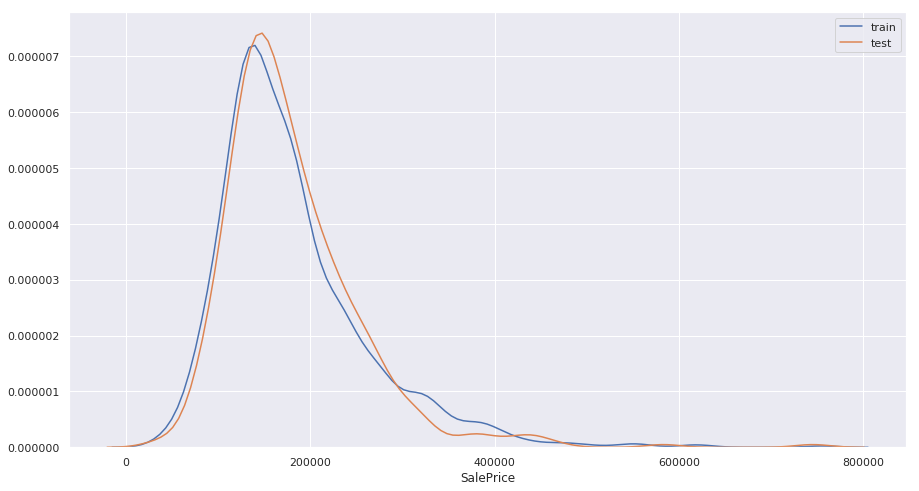

In [22]:
sns.distplot(train_df['SalePrice'], hist=False, rug=False, label='train')
sns.distplot(test_df['SalePrice'], hist=False, rug=False, label='test')

### Training

,mae ($),r2
Simple Linear Regression,19784.566646,0.847647


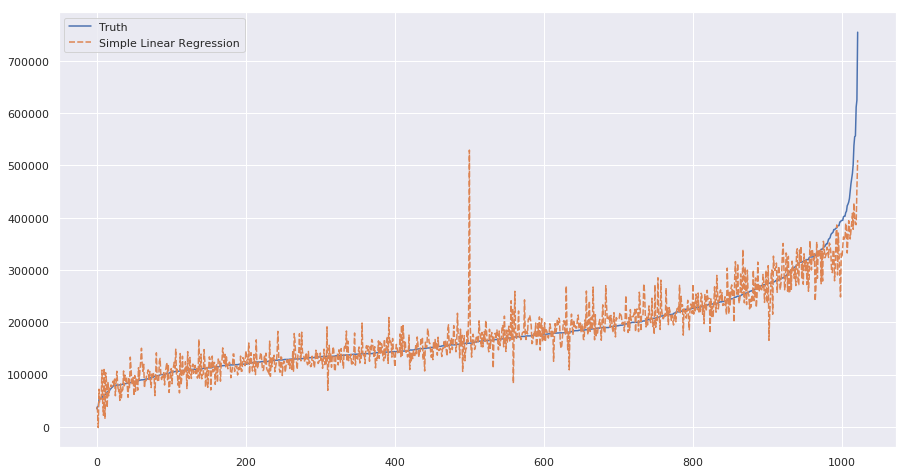

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

lin_regressor = LinearRegression().fit(train_df[features], train_df[[target]])

def plot_results(results):
  sns.lineplot(data=results.sort_values('Truth').reset_index().drop(columns=['Id']))
  
def compute_scores(method, results):
  return pd.Series(
    data=[mean_absolute_error(results['Truth'], results[method]), 
          r2_score(results['Truth'], results[method])],
    index=['mae ($)', 'r2'],
    name=method)
  
train_results_df = train_df[[target]].rename(columns={target: 'Truth'})
train_results_df['Simple Linear Regression'] = lin_regressor.predict(train_df[features])
plot_results(train_results_df)

train_score_df = pd.DataFrame()
train_score_df = train_score_df.append(compute_scores('Simple Linear Regression', train_results_df))
train_score_df

### Testing

,mae ($),r2
Simple Linear Regression,21258.440472,0.777479


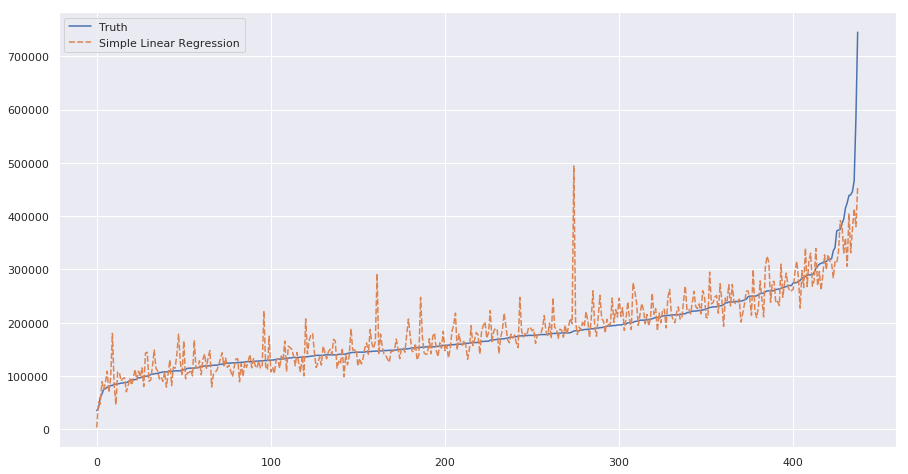

In [24]:
test_result_df = test_df[[target]].rename(columns={target: 'Truth'})
test_result_df['Simple Linear Regression'] = lin_regressor.predict(test_df[features])
plot_results(test_result_df)


test_score_df = pd.DataFrame()
test_score_df = test_score_df.append(compute_scores('Simple Linear Regression', test_result_df))
test_score_df

### Understanding the learned model

In [25]:
pd.DataFrame(data=lin_regressor.coef_[0], columns=['coef'], index=features).sort_values('coef', ascending=False)

,coef
Neighborhood_StoneBr,79578.538700
Neighborhood_NridgHt,76467.910082
Neighborhood_NoRidge,74965.879689
Neighborhood_Somerst,53606.178872
Neighborhood_Veenker,51843.480410
Neighborhood_Crawfor,45386.068395
Neighborhood_BrkSide,44867.198026
Neighborhood_IDOTRR,40690.552393
MSZoning_RH,37703.873689
Neighborhood_MeadowV,37484.604703


## Random Forest

### Training

,mae ($),r2
Simple Linear Regression,19784.566646,0.847647
Random Forest,8385.977123,0.967652


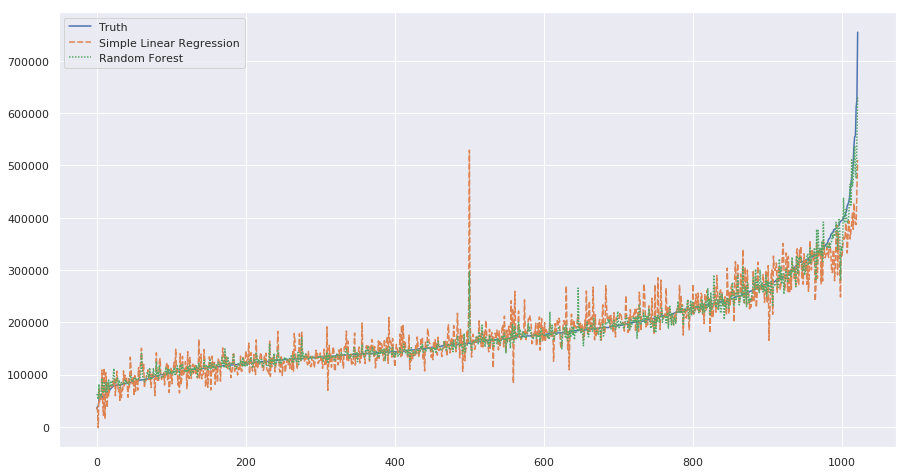

In [26]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor().fit(train_df[features], train_df[[target]])
  
train_results_df['Random Forest'] = rf_regressor.predict(train_df[features])
plot_results(train_results_df)

train_score_df = train_score_df.append(compute_scores('Random Forest', train_results_df))
train_score_df

### Testing

,mae ($),r2
Simple Linear Regression,21258.440472,0.777479
Random Forest,20619.593303,0.759932


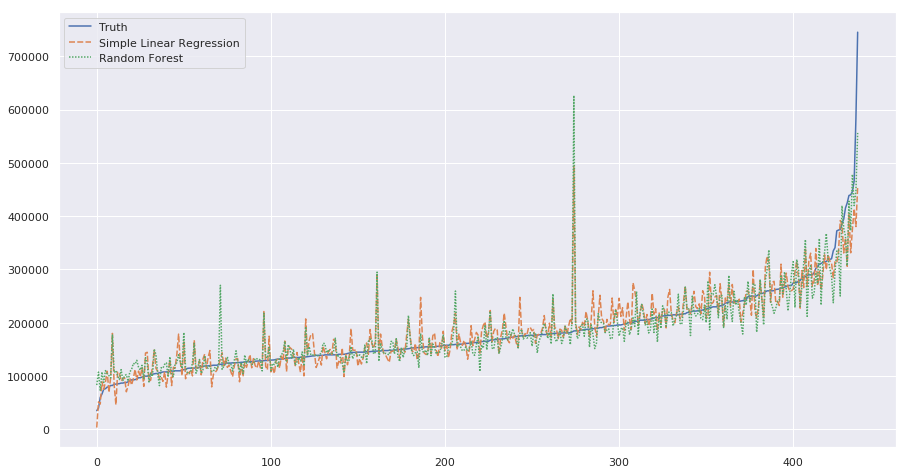

In [27]:
test_result_df['Random Forest'] = rf_regressor.predict(test_df[features])
plot_results(test_result_df)


test_score_df = test_score_df.append(compute_scores('Random Forest', test_result_df))
test_score_df